In [1]:
import numpy as np
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor


from pathlib import Path
from dotenv import load_dotenv
import os
load_dotenv()

True

In [24]:
HOST_CODE_PATH = Path(os.getenv("HOST_CODE_PATH"))
CONTAINER_CODE_PATH = Path(os.getenv("CONTAINER_CODE_PATH"))

DATA_PATH = HOST_CODE_PATH / 'data' / 'raw' / 'online_retail.parquet'
CLEANED =  HOST_CODE_PATH / 'data' / 'processed'

df = pd.read_parquet(DATA_PATH)

# Pipe

In [55]:



class AdvancedDemandForecastPipeline:
    def __init__(self, df, output_dir):
        self.df = df.copy()
        self.df_filtered = None
        self.output_dir = output_dir
        self.df_final = None
       

    def preprocess(self):
        df = self.df.copy()

        df = df[df['UnitPrice'] > 0].copy()

        df = df.drop_duplicates(subset=df.columns.difference(['InvoiceNo']))


        df['log_Quantity'] = np.log1p(df['Quantity'].clip(lower=0))
        df['log_UnitPrice'] = np.log1p(df['UnitPrice'].clip(lower=1e-6))
        df['TotalSum'] = df['Quantity'] * df['UnitPrice']
        df['log_TotalSum'] = np.log1p((df['Quantity'].clip(lower=0) *  df['UnitPrice'].clip(lower=1e-6)).clip(lower=0))
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
        df['TransactionHour'] = df['InvoiceDate'].dt.hour
        df['DayOfYear'] = df['InvoiceDate'].dt.dayofyear

        self.df_filtered = df

        
        return self


    def extract_temporal_features(self):
        dt = self.df_filtered['InvoiceDate'].dt
        temporal_features = {
            'Year': dt.year,
            'Month': dt.month,
            'Week': dt.isocalendar().week.astype(int),
            'Day': dt.day,
            'Weekday': dt.weekday + 1,
            'IsWeekend': ((dt.weekday + 1).isin([6, 7])).astype(int),  # 6=Saturday, 7=Sunday
            'HolidaySeason': dt.month.isin([11, 12]).astype(int),
            'IsStartOfMonth': dt.is_month_start.astype(int),
            'IsEndOfMonth': dt.is_month_end.astype(int),
            'BlackFriday': (dt.month == 11) & (dt.day >= 23) & (dt.day <= 29) & (dt.weekday == 4)
        }

       
         
        self.df_filtered = self.df_filtered.assign(**temporal_features)
        return self

    def calculate_and_merge_rfm(self):
        df = self.df_filtered.dropna(subset=['CustomerID'])

        last_date = df['InvoiceDate'].max() + timedelta(days=1)
        
        rfm = df.groupby('CustomerID').agg(
            Recency=('InvoiceDate', lambda x: (last_date - x.max()).days),
            Frequency=('InvoiceNo', 'nunique'),
            Monetary=('TotalSum', 'sum')
        ).reset_index()

        scaler = StandardScaler()
        rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

        kmeans = KMeans(n_clusters=3, random_state=42)
        rfm['RFM_Cluster'] = kmeans.fit_predict(rfm_scaled)

        self.df_filtered = self.df_filtered.merge(
            rfm[['CustomerID', 'RFM_Cluster']],
            on='CustomerID',
            how='left'
        )
        

        return self

    
    def generate_lags_and_rolling(self):
        required_cols = {'StockCode', 'Quantity', 'InvoiceDate'}
        if not required_cols.issubset(self.df_filtered.columns):
            raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
        clean_df = self.df_filtered[
            (self.df_filtered['Quantity'].between(1, 999)) & 
            (self.df_filtered['UnitPrice'].between(0.01, 9999))
        ].copy()
    
        agg = (clean_df
              .groupby(["InvoiceDate", "StockCode"], as_index=False)
              ["Quantity"]
              .sum()
              .rename(columns={"Quantity": "Quantity_Agg"})
              .sort_values(["StockCode", "InvoiceDate"])
              .reset_index(drop=True))
    
        # Порог для обрезки по квантилю
        q_low, q_high = agg["Quantity_Agg"].quantile([0.01, 0.99])
    
        # Лаги
        for lag in [1, 7, 30]:
            lag_vals = agg.groupby('StockCode')['Quantity_Agg'].shift(lag)
            agg[f'Lag_{lag}'] = lag_vals.clip(lower=q_low, upper=q_high).fillna(0).values
    
        # Роллинги
        for window in [7, 30]:
            group = agg.groupby('StockCode')['Quantity_Agg']
    
            rolling_mean = group.rolling(window=window, min_periods=1).mean()
            rolling_std = group.rolling(window=window, min_periods=1).std().fillna(1)
            agg[f'RollingNormMean_{window}'] = (
                (rolling_mean / rolling_std)
                .clip(lower=q_low, upper=q_high)
                .values
            )
    
            rolling_range = group.rolling(window=window, min_periods=1).max() - \
                            group.rolling(window=window, min_periods=1).min()
            agg[f'RollingRange_{window}'] = rolling_range.clip(lower=0, upper=q_high).fillna(0).values
    
        # Процентные изменения
        for name, (num, denom) in {'PctChange_7': ('Lag_1', 'Lag_7'),
                                   'PctChange_30': ('Lag_1', 'Lag_30')}.items():
            if denom in agg.columns:
                denom_vals = agg[denom].replace(0, np.nan)
                pct = (agg[num] - agg[denom]) / denom_vals
                agg[name] = pct.fillna(0).clip(-1, 1).values
    
        merge_cols = [c for c in agg.columns if c != 'Quantity_Agg']
        self.df_filtered = pd.merge(
            clean_df.reset_index(drop=True),
            agg[merge_cols].reset_index(drop=True),
            on=['InvoiceDate', 'StockCode'],
            how='left'
        )
    
        return self
                

    def filter_and_finalize(self):
        
        
        target = "log_Quantity"
        cols_to_drop = [
            'InvoiceNo', 'StockCode', 'Description', 'Country',
            'Quantity', 'TotalSum', 'UnitPrice'
        ]
        self.df_final = self.df_filtered.drop(
        columns=[col for col in cols_to_drop if col in self.df_filtered.columns])

        self.df_final = self.df_final.dropna()
        if self.df_final.empty:
            raise ValueError("Dataset is empty after NA removal")

        cat = ['IsWeekend', 'HolidaySeason', 'IsStartOfMonth', 'IsEndOfMonth', 'RFM_Cluster']

        numeric_cols = [
            col for col in self.df_final.select_dtypes(include=np.number).columns
            if col != target and col not in cat
        ]

        corr_matrix = self.df_final[numeric_cols + [target]].corr()
        target_corr = corr_matrix[target].abs().sort_values(ascending=False)
        print(target_corr)
        print(self.df_final.describe().T)


        self.selected_features = target_corr.index[1:16].tolist() + cat
        final_cols = self.selected_features + [target] 
     
        if 'InvoiceDate' in self.df_final.columns:
            self.df_final = self.df_final.sort_values('InvoiceDate').reset_index(drop=True)

        
        return self


    def save_outputs(self):
        files = {
            'final_data': self.output_dir / 'final_data.parquet',
            'good_features': self.output_dir / 'good_features.json'
        }

        self.df_final.to_parquet(files['final_data'], index=False)

        files['good_features'].write_text(json.dumps(self.selected_features))

        return files

    


In [56]:
pipeline = AdvancedDemandForecastPipeline(df, output_dir=CLEANED)


In [57]:
pipeline.preprocess()
pipeline.extract_temporal_features()

In [58]:
pipeline.calculate_and_merge_rfm()


In [59]:
pipeline.generate_lags_and_rolling()

In [60]:
pipeline.filter_and_finalize()

log_Quantity          1.000000
log_TotalSum          0.690592
log_UnitPrice         0.405087
RollingRange_7        0.362389
RollingRange_30       0.301627
TransactionHour       0.207907
Lag_1                 0.198770
Lag_7                 0.172834
Lag_30                0.150953
Year                  0.046642
PctChange_30          0.022625
RollingNormMean_7     0.020295
DayOfYear             0.015710
Month                 0.015695
Week                  0.015540
RollingNormMean_30    0.015028
PctChange_7           0.013337
Weekday               0.004278
Day                   0.002655
Name: log_Quantity, dtype: float64
                       count                           mean  \
InvoiceDate           524178  2011-07-04 17:43:52.334970624   
log_Quantity        524178.0                       1.717029   
log_UnitPrice       524178.0                       1.241306   
log_TotalSum        524178.0                       2.339974   
TransactionHour     524178.0                      13.073822  

In [61]:
pipeline.save_outputs()

{'final_data': WindowsPath('C:/Users/Ekaterina/sber_de/demand_project/data/processed/final_data.parquet'),
 'good_features': WindowsPath('C:/Users/Ekaterina/sber_de/demand_project/data/processed/good_features.json')}

# ml

In [62]:
DATA_PATH = HOST_CODE_PATH / 'data' / 'processed' / 'final_data.parquet'
FEATURES_PATH = HOST_CODE_PATH / 'data' / 'processed' / 'good_features.json'
df = pd.read_parquet(DATA_PATH)
with open(FEATURES_PATH, 'r') as f:
    features = json.load(f)

In [63]:
import os
from datetime import datetime
import json
import numpy as np
import joblib
import pandas as pd
from copy import deepcopy
from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


In [ ]:
def scale_and_write_back(df_train, df_test, features, target):
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()

    df_train_scaled[features] = scaler_X.fit_transform(df_train[features])
    df_test_scaled[features] = scaler_X.transform(df_test[features])

    df_train_scaled[target] = scaler_y.fit_transform(df_train[[target]])
    df_test_scaled[target] = scaler_y.transform(df_test[[target]])

    return df_train_scaled, df_test_scaled, scaler_X, scaler_y

In [ ]:
def create_multivariate_sequences(df, features, target, window_size):
    feature_values = df[features].values
    target_values = df[target].values
    n_samples = len(df) - window_size

    X = np.zeros((n_samples, window_size, len(features)))
    y = np.zeros(n_samples)

    for i in range(window_size, len(df)):
        X[i - window_size] = feature_values[i - window_size:i]
        y[i - window_size] = target_values[i]

    indices = df.index[window_size:]
    return X, y, indices

In [ ]:
def build_lstm_model(window_size, n_features):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(window_size, n_features), return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [12]:
from sklearn.model_selection import TimeSeriesSplit
from collections import Counter
tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []

In [ ]:
def predict_and_evaluate(model, X_test_seq, y_test_seq, scaler_y):
    y_pred_scaled = model.predict(X_test_seq)

    # inverse scaling
    y_pred_log = scaler_y.inverse_transform(y_pred_scaled)
    y_true_log = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

    # inverse log1p
    y_pred = np.expm1(y_pred_log).flatten()
    y_true = np.expm1(y_true_log).flatten()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return rmse, mae

In [13]:

target = "log_Quantity"
window_size = 15

In [14]:
df

,InvoiceDate,CustomerID,log_Quantity,log_UnitPrice,log_TotalSum,TransactionHour,DayOfYear,Year,Month,Week,...,RFM_Cluster,Lag_1,Lag_7,Lag_30,RollingNormMean_7,RollingRange_7,RollingNormMean_30,RollingRange_30,PctChange_7,PctChange_30
0,2010-12-02 14:07:00,17850.0,1.945910,1.047319,2.493205,14,336,2010,12,48,...,0,6.0,6.0,6.0,1.391912,18.0,0.691345,95.0,0.000000,0.000000
1,2010-12-02 15:24:00,17850.0,1.945910,1.266948,2.791165,15,336,2010,12,48,...,0,12.0,6.0,6.0,1.844641,11.0,0.562894,127.0,1.000000,1.000000
2,2010-12-02 15:25:00,17850.0,1.945910,1.047319,2.493205,15,336,2010,12,48,...,0,6.0,13.0,6.0,1.259882,18.0,0.691345,95.0,-0.538462,0.000000
3,2010-12-02 15:26:00,17850.0,2.564949,1.373716,3.594569,15,336,2010,12,48,...,0,6.0,12.0,6.0,1.844641,11.0,0.570141,127.0,-0.500000,0.000000
4,2010-12-02 15:27:00,17850.0,2.564949,1.047319,3.144152,15,336,2010,12,48,...,0,6.0,24.0,6.0,3.023716,6.0,0.704490,95.0,-0.750000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431874,2011-12-09 12:50:00,12680.0,2.564949,0.974560,3.034953,12,343,2011,12,49,...,2,12.0,1.0,1.0,1.204388,23.0,1.129010,23.0,1.000000,1.000000
431875,2011-12-09 12:50:00,12680.0,2.564949,0.974560,3.034953,12,343,2011,12,49,...,2,12.0,24.0,12.0,1.301889,23.0,1.088141,23.0,-0.500000,0.000000
431876,2011-12-09 12:50:00,12680.0,1.609438,1.638997,2.867899,12,343,2011,12,49,...,2,12.0,8.0,4.0,1.525108,9.0,0.459101,71.0,0.500000,1.000000
431877,2011-12-09 12:50:00,12680.0,1.609438,1.558145,2.772589,12,343,2011,12,49,...,2,5.0,4.0,4.0,2.049003,4.0,0.973466,23.0,0.250000,0.250000


In [64]:
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
test_size = len(df) - train_size - val_size

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size+val_size]
test_df = df.iloc[train_size+val_size:]


In [65]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaler_X.fit(train_df[features])
scaler_y.fit(train_df[[target]])

train_X_scaled = scaler_X.transform(train_df[features])
train_y_scaled = scaler_y.transform(train_df[[target]])

val_X_scaled = scaler_X.transform(val_df[features])
val_y_scaled = scaler_y.transform(val_df[[target]])

test_X_scaled = scaler_X.transform(test_df[features])
test_y_scaled = scaler_y.transform(test_df[[target]])

In [66]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# 4. Генерируем выборки
X_train, y_train = create_sequences(train_X_scaled, train_y_scaled, window_size)
X_val, y_val = create_sequences(val_X_scaled, val_y_scaled, window_size)
X_test, y_test = create_sequences(test_X_scaled, test_y_scaled, window_size)

# 5. Создаём модель LSTM
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, len(features))),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 6. Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 7. Обучаем модель
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    shuffle=False,  # важно для временных рядов
    callbacks=[early_stop],
    verbose=1
)


C:\Users\Ekaterina\anaconda3\envs\demand_forecast\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6552/6552 ━━━━━━━━━━━━━━━━━━━━ 73s 11ms/step - loss: 0.5328 - mae: 0.5457 - val_loss: 0.5067 - val_mae: 0.5376
Epoch 2/50
6552/6552 ━━━━━━━━━━━━━━━━━━━━ 76s 12ms/step - loss: 0.5140 - mae: 0.5332 - val_loss: 0.5025 - val_mae: 0.5336
Epoch 3/50
6552/6552 ━━━━━━━━━━━━━━━━━━━━ 74s 11ms/step - loss: 0.5093 - mae: 0.5301 - val_loss: 0.5057 - val_mae: 0.5386
Epoch 4/50
6552/6552 ━━━━━━━━━━━━━━━━━━━━ 74s 11ms/step - loss: 0.5065 - mae: 0.5283 - val_loss: 0.5039 - val_mae: 0.5329
Epoch 5/50
6552/6552 ━━━━━━━━━━━━━━━━━━━━ 76s 12ms/step - loss: 0.5042 - mae: 0.5268 - val_loss: 0.5082 - val_mae: 0.5392
Epoch 6/50
6552/6552 ━━━━━━━━━━━━━━━━━━━━ 74s 11ms/step - loss: 0.5027 - mae: 0.5260 - val_loss: 0.5047 - val_mae: 0.5360
Epoch 7/50
6552/6552 ━━━━━━━━━━━━━━━━━━━━ 75s 11ms/step - loss: 0.5013 - mae: 0.5252 - val_loss: 0.5040 - val_mae: 0.5364


In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model_log_target(model, X, y_scaled, scaler_y):
    # Предсказания в масштабе стандартизированных лог-значений
    y_pred_scaled = model.predict(X)
    
    # Обратно к логарифму (inverse scaling)
    y_pred_log = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_true_log = scaler_y.inverse_transform(y_scaled.reshape(-1, 1))
    
    # Обратно к исходной шкале (снятие логарифма)
    y_pred = np.expm1(y_pred_log).flatten()
    y_true = np.expm1(y_true_log).flatten()
    
    # Метрики
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {"MSE": mse, "MAE": mae, "R2": r2}, y_true, y_pred


print("Train:", metrics_train)
print("Val:  ", metrics_val)
print("Test: ", metrics_test)


13104/13104 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Train: ({'MSE': 659.8027356038054, 'MAE': 6.716855270368426, 'R2': 0.20271559808299278}, array([3., 3., 3., ..., 8., 6., 6.]), array([ 6.3887806,  5.5027037,  5.1295624, ..., 16.638577 , 11.18008  ,
        9.32033  ], dtype=float32))
Val:   ({'MSE': 543.8804132390579, 'MAE': 6.1767654696983545, 'R2': 0.19005210204603418}, array([10., 48., 48., ..., 36., 48., 50.]), array([ 8.92873 ,  8.770889, 12.460485, ..., 18.48778 , 19.524231,
       22.980045], dtype=float32))
Test:  ({'MSE': 453.8849731113927, 'MAE': 5.547396010346526, 'R2': 0.18260429169376546}, array([24., 25.,  6., ...,  4.,  4.,  3.]), array([11.91028 , 14.170774, 16.22388 , ...,  8.6088  ,  6.907523,
        6.161826], dtype=float32))


In [73]:
metrics_train, y_train_true, y_train_pred = evaluate_model_log_target(model, X_train, y_train, scaler_y)
metrics_val, y_val_true, y_val_pred = evaluate_model_log_target(model, X_val, y_val, scaler_y)
metrics_test, y_test_true, y_test_pred = evaluate_model_log_target(model, X_test, y_test, scaler_y)

print("Train:", metrics_train)
print("Val:  ", metrics_val)
print("Test: ", metrics_test)

13104/13104 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Train: {'MSE': 659.8027356038054, 'MAE': 6.716855270368426, 'R2': 0.20271559808299278}
Val:   {'MSE': 543.8804132390579, 'MAE': 6.1767654696983545, 'R2': 0.19005210204603418}
Test:  {'MSE': 453.8849731113927, 'MAE': 5.547396010346526, 'R2': 0.18260429169376546}


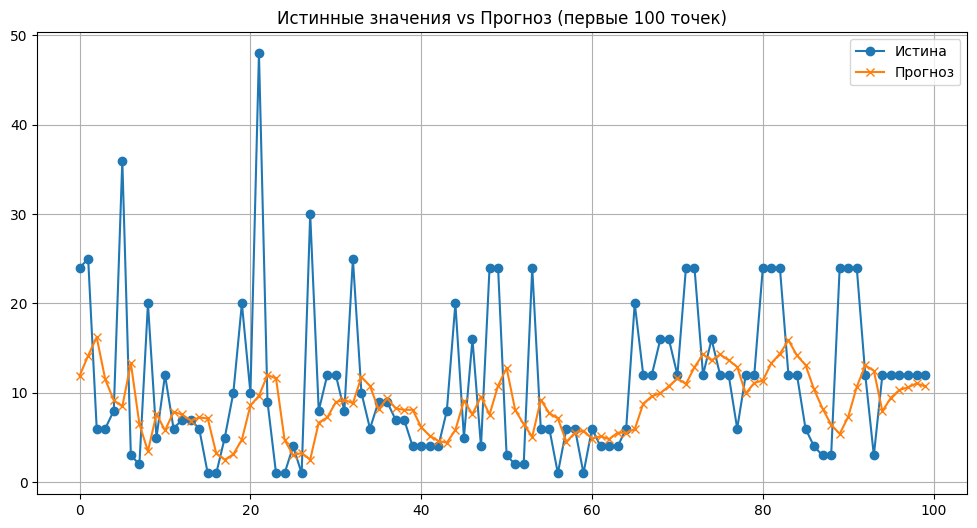

In [75]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 6))
plt.plot(y_test_true[:100], label='Истина', marker='o')
plt.plot(y_test_pred[:100], label='Прогноз', marker='x')
plt.title("Истинные значения vs Прогноз (первые 100 точек)")
plt.legend()
plt.grid()
plt.show()

In [76]:
results = pd.DataFrame({
    "y_true": y_test_true,
    "y_pred": y_test_pred
})


In [77]:
results

,y_true,y_pred
0,24.0,11.910280
1,25.0,14.170774
2,6.0,16.223881
3,6.0,11.505861
4,8.0,9.164413
...,...,...
52399,12.0,5.894982
52400,12.0,7.580073
52401,4.0,8.608800
52402,4.0,6.907523
